Below is code with a link to a happy or sad dataset which contains 80 images, 40 happy and 40 sad. 
Create a convolutional neural network that trains to 100% accuracy on these images,  which cancels training upon hitting training accuracy of >.999

Hint -- it will work best with 3 convolutional layers.

In [0]:
#checking gpu status
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#importing other libraries

from tensorflow import keras
import os
import zipfile

In [0]:
#downloading file

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

--2019-04-21 18:33:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.01s   

2019-04-21 18:33:38 (173 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



In [0]:
#unzippig file

zip_ref = zipfile.ZipFile('/tmp/happy-or-sad.zip', 'r')
zip_ref.extractall('/tmp/h-o-s')
zip_ref.close()

In [0]:
#checking what kind of data we are dealing with

train_happy_dir = os.path.join('/tmp/h-o-s/happy')
train_sad_dir = os.path.join('/tmp/h-o-s/sad')

train_happy_names = os.listdir(train_happy_dir)
train_sad_names = os.listdir(train_sad_dir)

In [0]:
print('Number of happy samples for training: {}'.format(len(train_happy_names)))
print('Number of sad samples for training: {}'.format(len(train_sad_names)))

Number of happy samples for training: 40
Number of sad samples for training: 40


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index += 8
next_happy_pics = [os.path.join(train_happy_dir, file_name) for file_name in train_happy_names[pic_index-8 : pic_index]]
next_sad_pics = [os.path.join(train_sad_dir, file_name) for file_name in train_sad_names[pic_index-8 : pic_index]]

<Figure size 1152x1152 with 0 Axes>

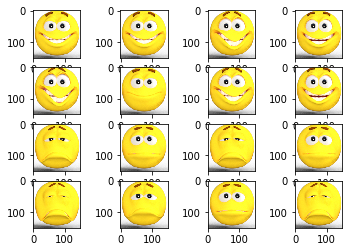

In [0]:
for i, img_path in enumerate(next_happy_pics + next_sad_pics):
  sp = plt.subplot(nrows, ncols, i+1)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show()

In [0]:
#Creating Model

model = keras.models.Sequential ([
    keras.layers.Conv2D(16, (3,3), input_shape = (150,150,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dense(units = 1, activation = 'sigmoid')]
)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0         
__________

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop (lr = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)
image_directory = '/tmp/h-o-s'

train_generator = train_datagen.flow_from_directory (
                 image_directory,
                 target_size = (150,150),
                 batch_size = 8,
                 class_mode = 'binary'
)

Found 80 images belonging to 2 classes.


In [0]:
#creating callback feature

desired_accuracy = 0.999

class myCallback (tf.keras.callbacks.Callback):
  def on_epoch_end (self, epoch, logs={}):
    if (logs.get('acc') > desired_accuracy):
      print("\nReached {}% accuracy so cancelling training!".format(100*desired_accuracy))
      self.model.stop_training = True

callbacks = myCallback()


In [0]:
#Training the model

model.fit_generator(train_generator, epochs = 15, steps_per_epoch = 5, verbose = 1, callbacks = [callbacks])

Epoch 1/15
 9/10 [==========================>...] - ETA: 0s - loss: 7.3924e-05 - acc: 1.0000
Reached 99.9% accuracy so cancelling training!
10/10 [==============================] - 0s 16ms/step - loss: 7.6478e-05 - acc: 1.0000


In [0]:
#testing the model using uploaded image

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded_image = files.upload()

for fn in uploaded_image.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size = (150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is happy")
  else:
    print(fn + " is sad")

Saving sad6.jpg to sad6.jpg
Saving sad5.jpg to sad5.jpg
Saving sad4.png to sad4.png
Saving sad3.png to sad3 (1).png
Saving sad2.jpg to sad2 (2).jpg
Saving sad.png to sad (1).png
Saving happy7.png to happy7 (1).png
Saving happy6.jpg to happy6 (1).jpg
Saving happy5.png to happy5 (1).png
Saving happy4.jpg to happy4.jpg
Saving happy2.jpg to happy2 (1).jpg
Saving happy.jpg to happy.jpg
[6.4368167e-22]
sad6.jpg is sad
[1.]
sad5.jpg is happy
[0.]
sad4.png is sad
[0.]
sad3.png is sad
[1.]
sad2.jpg is happy
[0.]
sad.png is sad
[0.]
happy7.png is sad
[0.]
happy6.jpg is sad
[0.]
happy5.png is sad
[0.]
happy4.jpg is sad
[1.]
happy2.jpg is happy
[1.]
happy.jpg is happy


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
